## Tabla con 100 features para modelamietno


--- Satisfacción ---
Matriz de confusión:
[[10911  4290]
 [ 2833  1855]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75     15201
           1       0.30      0.40      0.34      4688

    accuracy                           0.64     19889
   macro avg       0.55      0.56      0.55     19889
weighted avg       0.68      0.64      0.66     19889

AUC-ROC: 0.5829120656356136
Threshold óptimo (F1-max): 0.43001178


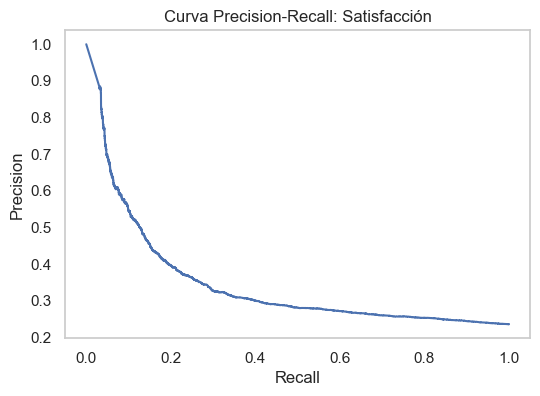


--- Churn ---
Matriz de confusión:
[[13105  3877]
 [ 1755  1152]]

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82     16982
           1       0.23      0.40      0.29      2907

    accuracy                           0.72     19889
   macro avg       0.56      0.58      0.56     19889
weighted avg       0.79      0.72      0.75     19889

AUC-ROC: 0.608599588864342
Threshold óptimo (F1-max): 0.49705246


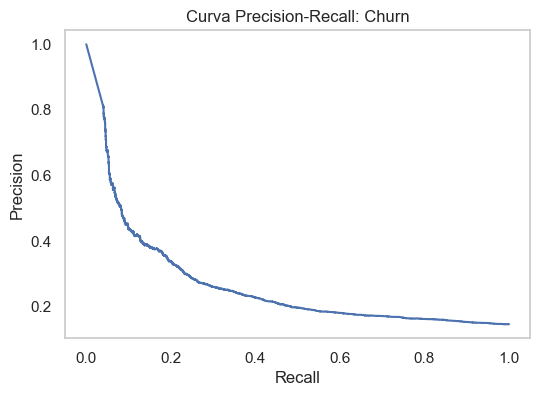

In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# -----------------------------
# 1. Cargar datasets
# -----------------------------
orders = pd.read_csv("./dataset/olist_orders_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")

# Merge datasets
df = orders.merge(reviews, on="order_id", how="left")
df = df.merge(items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")

# -----------------------------
# 2. Crear variable satisfacción
# -----------------------------
# 0 = satisfecho (score >=4), 1 = insatisfecho (score <=3)
df['satisfaction'] = df['review_score'].apply(lambda x: 0 if x >= 4 else 1)

# -----------------------------
# 3. Crear variable churn
# -----------------------------
# Aquí consideramos churn = 1 si cliente alguna vez dio review <=2
df['churn_flag'] = df['review_score'].apply(lambda x: 1 if x <= 2 else 0)

# -----------------------------
# 4. Agregar features por cliente
# -----------------------------
df_customer = df.groupby('customer_id').agg({
    'satisfaction':'max',        # si alguna compra insatisfecha → insatisfecho
    'churn_flag':'max',          # si alguna compra mala → churn
    'order_id':'count',           # total compras
    'price':'mean',               # avg price
    'freight_value':'mean',       # avg freight
    'product_id':'nunique'        # num productos distintos
}).reset_index()

df_customer.rename(columns={
    'order_id':'total_orders',
    'price':'avg_order_value',
    'freight_value':'avg_freight',
    'product_id':'num_products'
}, inplace=True)

# -----------------------------
# 5. Features y targets
# -----------------------------
features = ['total_orders','avg_order_value','avg_freight','num_products']

X = df_customer[features]

y_satisfaction = df_customer['satisfaction']
y_churn = df_customer['churn_flag']

# -----------------------------
# 6. Split train/test
# -----------------------------
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_satisfaction, test_size=0.2, random_state=42, stratify=y_satisfaction
)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

# -----------------------------
# 7. Calcular scale_pos_weight
# -----------------------------
scale_s = sum(y_train_s==0)/sum(y_train_s==1)
scale_c = sum(y_train_c==0)/sum(y_train_c==1)

# -----------------------------
# 8. Entrenar modelos XGBoost
# -----------------------------
xgb_s = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=scale_s,
    eval_metric='logloss'
)
xgb_s.fit(X_train_s, y_train_s)

xgb_c = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=scale_c,
    eval_metric='logloss'
)
xgb_c.fit(X_train_c, y_train_c)

# -----------------------------
# 9. Predicciones
# -----------------------------
y_pred_s = xgb_s.predict(X_test_s)
y_pred_c = xgb_c.predict(X_test_c)

y_proba_s = xgb_s.predict_proba(X_test_s)[:,1]
y_proba_c = xgb_c.predict_proba(X_test_c)[:,1]

# -----------------------------
# 10. Métricas
# -----------------------------
def report_metrics(y_test, y_pred, y_proba, name):
    print(f"\n--- {name} ---")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2*(precision*recall)/(precision+recall+1e-9)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print("Threshold óptimo (F1-max):", best_threshold)
    
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision)
    plt.title(f"Curva Precision-Recall: {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()
    return best_threshold

# Report
best_thresh_s = report_metrics(y_test_s, y_pred_s, y_proba_s, "Satisfacción")
best_thresh_c = report_metrics(y_test_c, y_pred_c, y_proba_c, "Churn")


In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Cargar datasets
# -----------------------------
orders = pd.read_csv("./dataset/olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'])
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
customers = pd.read_csv("./dataset/olist_customers_dataset.csv")
payments = pd.read_csv("./dataset/olist_order_payments_dataset.csv")

# Merge datasets
df = orders.merge(reviews, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')

# -----------------------------
# 2. Variable objetivo: satisfacción
# -----------------------------
df['satisfaction'] = df['review_score'].apply(lambda x: 0 if x >= 4 else 1)

# -----------------------------
# 3. Features derivadas por cliente (sin usar review_score directamente)
# -----------------------------
df_customer = df.groupby('customer_id').agg({
    'order_id':'count',           # total compras
    'price':'sum',                # total gastado
    'freight_value':'sum',        # total envío
    'product_id':'nunique',       # productos distintos
    'payment_type':'nunique',     # diversidad de pagos
    'order_purchase_timestamp':'min',
    'order_delivered_customer_date':'max'
}).reset_index()

# Renombrar columnas
df_customer.rename(columns={
    'order_id':'total_orders',
    'price':'total_spent',
    'freight_value':'total_freight',
    'product_id':'num_products',
    'payment_type':'num_payment_types',
    'order_purchase_timestamp':'first_order_date',
    'order_delivered_customer_date':'last_order_date'
}, inplace=True)

# -----------------------------
# 4. Features temporales
# -----------------------------
today = pd.Timestamp('2025-11-17')
df_customer['days_since_last_order'] = (today - df_customer['last_order_date']).dt.days
df_customer['customer_lifetime'] = (df_customer['last_order_date'] - df_customer['first_order_date']).dt.days
df_customer['avg_days_between_orders'] = df_customer['customer_lifetime'] / df_customer['total_orders']

# -----------------------------
# 5. Features de pago
# -----------------------------
payment_features = df.groupby('customer_id')['payment_type'].value_counts().unstack(fill_value=0)
payment_features.columns = [f'payment_count_{col}' for col in payment_features.columns]
df_customer = df_customer.merge(payment_features, left_on='customer_id', right_index=True, how='left')

# -----------------------------
# 6. Features de entrega
# -----------------------------
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df_customer['avg_delivery_delay'] = df.groupby('customer_id')['delivery_delay'].mean().fillna(0)
df_customer['late_delivery_count'] = df.groupby('customer_id')['delivery_delay'].apply(lambda x: (x>3).sum())

# -----------------------------
# 7. Features por producto
# -----------------------------
df_customer['avg_price_per_product'] = df_customer['total_spent'] / df_customer['num_products']
df_customer['avg_freight_per_product'] = df_customer['total_freight'] / df_customer['num_products']

# -----------------------------
# 8. Preparar dataset
# -----------------------------
X = df_customer.drop(columns=['customer_id','first_order_date','last_order_date'])
y = df['satisfaction'].groupby(df['customer_id']).max()  # agrega satisfacción máxima por cliente
X = X.fillna(0)

# -----------------------------
# 9. Split train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 10. Entrenar XGBoost y obtener importancia
# -----------------------------
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

# -----------------------------
# 11. Identificar tipo de variable
# -----------------------------
def var_type(col, df):
    if np.issubdtype(df[col].dtype, np.number):
        return 'numérica'
    elif np.issubdtype(df[col].dtype, np.datetime64):
        return 'temporal'
    else:
        return 'categórica'

feat_imp['type'] = feat_imp['feature'].apply(lambda f: var_type(f, X))

# -----------------------------
# 12. Seleccionar top 100 features
# -----------------------------
top_100_features = feat_imp.head(100).reset_index(drop=True)

# -----------------------------
# 13. Mostrar resultado
# -----------------------------
print(top_100_features)


c:\Users\ludwing.young\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:04:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                      feature  importance      type
0                total_orders    0.243702  numérica
1           customer_lifetime    0.222603  numérica
2                num_products    0.163326  numérica
3       days_since_last_order    0.125716  numérica
4           num_payment_types    0.050317  numérica
5   payment_count_credit_card    0.039584  numérica
6     avg_freight_per_product    0.026678  numérica
7               total_freight    0.023411  numérica
8       avg_price_per_product    0.019214  numérica
9                 total_spent    0.018138  numérica
10    avg_days_between_orders    0.017804  numérica
11       payment_count_boleto    0.017652  numérica
12      payment_count_voucher    0.017253  numérica
13   payment_count_debit_card    0.014601  numérica
14  payment_count_not_defined    0.000000  numérica
15        late_delivery_count    0.000000  numérica
16         avg_delivery_delay    0.000000  numérica


C:\Users\ludwing.young\AppData\Local\Temp\ipykernel_26296\3382933376.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_30, palette='viridis')


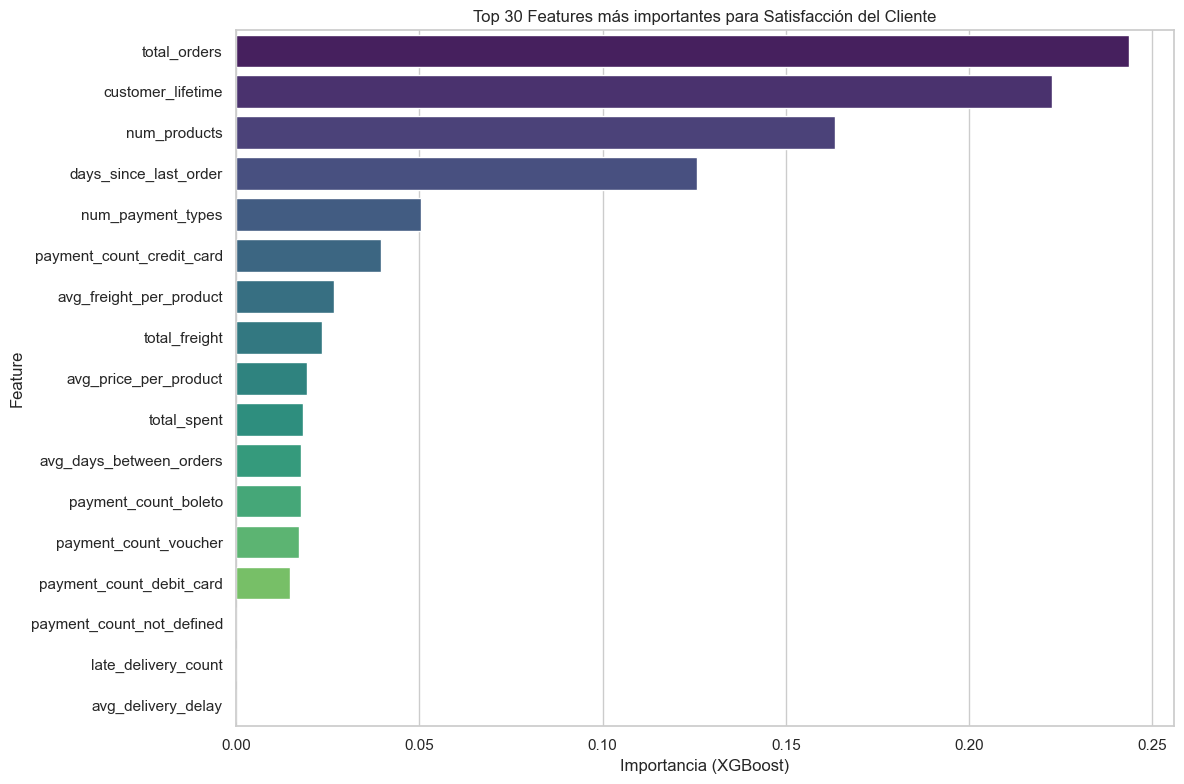

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar top 30 features
top_30 = top_100_features.head(30)

plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=top_30, palette='viridis')
plt.title("Top 30 Features más importantes para Satisfacción del Cliente")
plt.xlabel("Importancia (XGBoost)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


c:\Users\ludwing.young\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [11:13:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


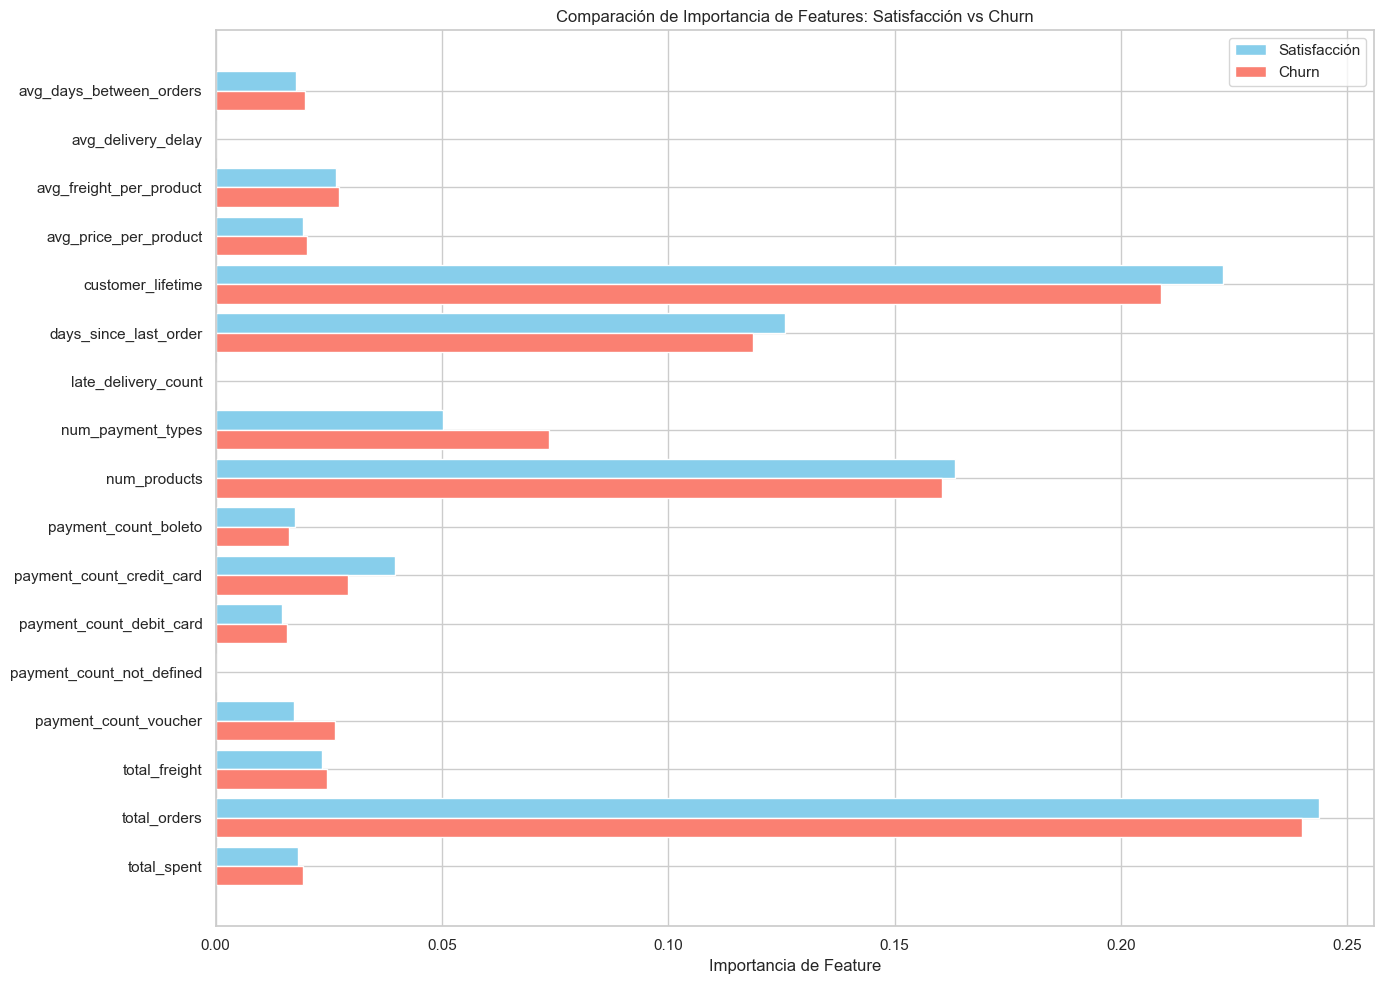

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# Preparar datos para churn
# -----------------------------
# Churn = 1 si alguna compra review_score <=2
df_customer['churn_flag'] = df.groupby('customer_id')['review_score'].apply(lambda x: (x<=2).max()).values

X_churn = X.copy()
y_churn = df_customer['churn_flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

xgb_c = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='logloss', use_label_encoder=False)
xgb_c.fit(X_train_c, y_train_c)

feat_imp_churn = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_c.feature_importances_
}).sort_values(by='importance', ascending=False)

# -----------------------------
# Combinar importancia de satisfacción y churn
# -----------------------------
top_features = 30
top_satisfaction = top_100_features.head(top_features)[['feature','importance']].rename(columns={'importance':'importance_satisfaction'})
top_churn = feat_imp_churn.head(top_features).rename(columns={'importance':'importance_churn'})

# Merge por feature
merged_imp = pd.merge(top_satisfaction, top_churn, on='feature', how='outer').fillna(0)

# -----------------------------
# Gráfico comparado
# -----------------------------
plt.figure(figsize=(14,10))
bar_width = 0.4
y_pos = np.arange(len(merged_imp))

plt.barh(y_pos - bar_width/2, merged_imp['importance_satisfaction'], height=bar_width, label='Satisfacción', color='skyblue')
plt.barh(y_pos + bar_width/2, merged_imp['importance_churn'], height=bar_width, label='Churn', color='salmon')

plt.yticks(y_pos, merged_imp['feature'])
plt.xlabel("Importancia de Feature")
plt.title("Comparación de Importancia de Features: Satisfacción vs Churn")
plt.legend()
plt.gca().invert_yaxis()  # Mostrar la más importante arriba
plt.tight_layout()
plt.show()
